In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tqdm
import DEBUG_Custom_MSE_Z as funcs
import pandas as pd
import time
from keras import backend as K
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dropout, Dense,Flatten, AveragePooling1D
from tensorflow.keras.layers import Input,  UpSampling1D
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
tf.config.list_physical_devices('GPU')


2023-03-28 21:46:41.302702: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-28 21:46:41.799145: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-03-28 21:46:42.807437: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-28 21:46:42.836432: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-28 21:46:42.836493: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_exec

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
class Autoencoder:
    def __init__(self, time_periods, cnn_model, x_train_scaled):
        self.time_periods = time_periods
        self.input_wave = Input(shape=(x_train_scaled.shape[1], 1))
        self.cnn_model = cnn_model
        
    def create_model(self):
        x = Conv1D(filters=16, kernel_size=3, strides=2, activation = "relu", 
                        weights=self.cnn_model.layers[0].get_weights() , input_shape=(self.time_periods,1))(self.input_wave)
        x = MaxPooling1D(pool_size=2)(x)
        
        #second convolutional block
        x = Conv1D(filters=32, kernel_size=5, strides=2, weights=self.cnn_model.layers[2].get_weights(), activation = "relu", )(x)
        x = MaxPooling1D(pool_size=2)(x)

        encoded = Conv1D(filters=64, kernel_size=9, weights=self.cnn_model.layers[5].get_weights(), activation = "relu")(x)
        
        x = Conv1D(filters=64, kernel_size=9, padding = "same", activation = "relu")(encoded)
        x = UpSampling1D(4)(x)
        x = Conv1D(filters=32, kernel_size=5, padding = "same", activation = "relu")(x)
        x = UpSampling1D(3)(x)
        x = Conv1D(filters=16, kernel_size=3,  activation = "relu")(x)
        x = UpSampling1D(6)(x)
        decoded = Conv1D(filters=1, kernel_size=5,  activation = "linear")(x)
        return Model(self.input_wave, decoded)

In [3]:
def custom_mse2(y_true, y_pred):
    print('DEBUG - sig_ranges_len: ' + str(len(sig_ranges)))
    np_y_true = y_true.numpy()
    batch_size = 1024  # hard coded for now
    batchIdx = int(int(alpha).numpy())

    left_idx = batchIdx*batch_size
    if int(int(valid_flag).numpy()) == 1:
        curr_sig_ranges = sig_ranges_valid
        curr_no_sig_ranges =  no_sig_ranges_valid
        print('DEBUG: starting validation: ' + str(len(curr_no_sig_ranges)))
    else:
        curr_sig_ranges = sig_ranges_train[left_idx:]
        curr_no_sig_ranges = no_sig_ranges_train[left_idx:]

    for i in range(10):
        print('DEBUG MESSAGE: ',curr_sig_ranges[i], '---', curr_no_sig_ranges[i])

    print('calculating MSEs')
    total_mse = 0
    print('np_true len: ' + str(len(np_y_true)), np_y_true.shape)
    
    if batchIdx == 156:
        for idx in tqdm.trange(32):
            if sum(np_y_true[idx]) == 0:
                # total_mse += funcs.calculate_single_mse_helper(np_y_true[i], np_y_pred[i])
                total_mse += 0.7*funcs.calculate_single_mse_helper(y_true[idx], y_pred[idx])
                # total_mse += 0.3*funcs.calculate_single_mse_helper(y_true[i], y_pred[i])

            else:
                # total_mse += funcs.calculate_single_mse(np_y_true[i], np_y_pred[i], sig_ranges[i])
                total_mse += funcs.calculate_single_mse(y_true[idx], y_pred[idx], curr_sig_ranges[idx], curr_no_sig_ranges[idx])
                batch_size = 32
    
    else:
        print('else case')
        for idx in tqdm.trange(loop_len):
            if sum(np_y_true[idx]) == 0:
                # total_mse += funcs.calculate_single_mse_helper(np_y_true[i], np_y_pred[i])
                total_mse += funcs.calculate_single_mse_helper(y_true[idx], y_pred[idx])
                # total_mse += 0.3*funcs.calculate_single_mse_helper(y_true[i], y_pred[i])

            else:
                # total_mse += funcs.calculate_single_mse(np_y_true[i], np_y_pred[i], sig_ranges[i])
                total_mse += funcs.calculate_single_mse(y_true[idx], y_pred[idx], curr_sig_ranges[idx], curr_no_sig_ranges[idx])
    
    loss = total_mse/batch_size

    return loss

    #-------------------------------------------------------------------------------

In [4]:
wireplane = 'Z'
path = '../../processed_data/current/'
x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled, mean, std = funcs.load_data(path, wireplane)

In [5]:
x_train = np.load(path+'x_train_'+ wireplane +'.npy')
x_test = np.load(path+'x_test_'+ wireplane +'.npy')
y_train = np.load(path+'y_train_AE_'+ wireplane +'.npy')
y_test = np.load(path+'y_test_AE_'+ wireplane +'.npy')

In [6]:
idx = 15

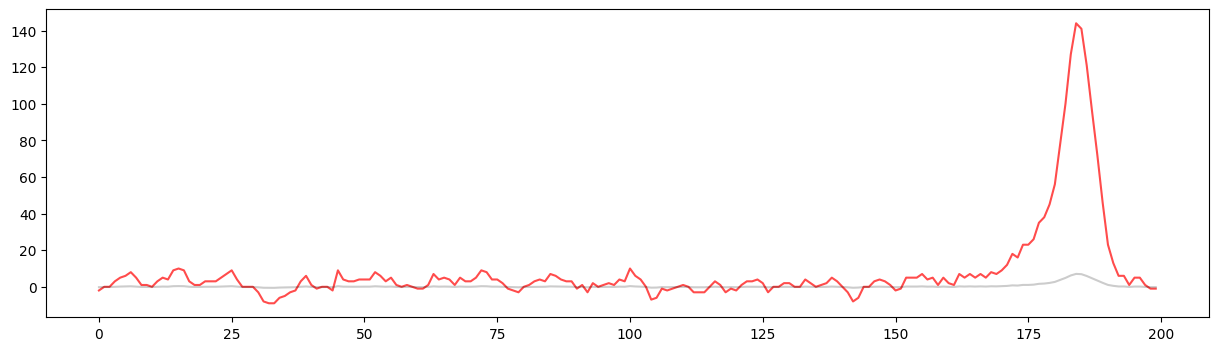

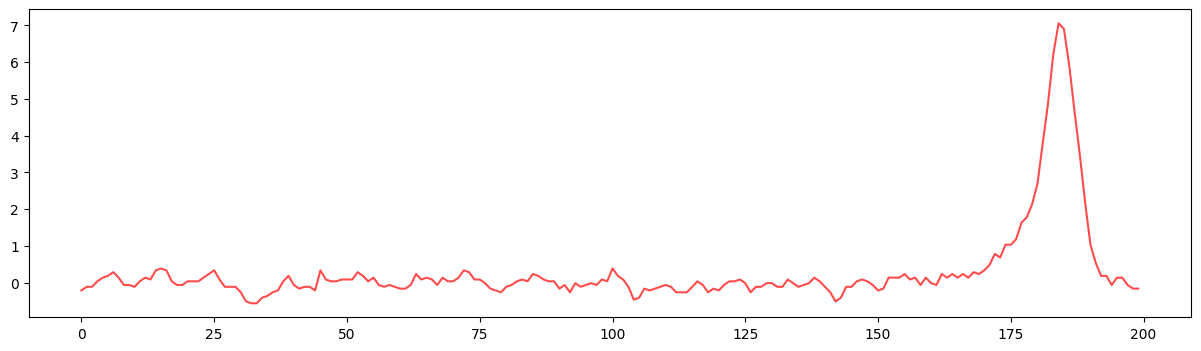

In [7]:
fig = plt.subplots(figsize=(15, 4), facecolor='white')
plt.plot(x_train[idx],color='red', label='target', alpha=0.7)
plt.plot(x_train_scaled[idx], color='black',alpha=0.2)

fig = plt.subplots(figsize=(15, 4), facecolor='white')
plt.plot(x_train_scaled[idx],color='red', label='target', alpha=0.7)

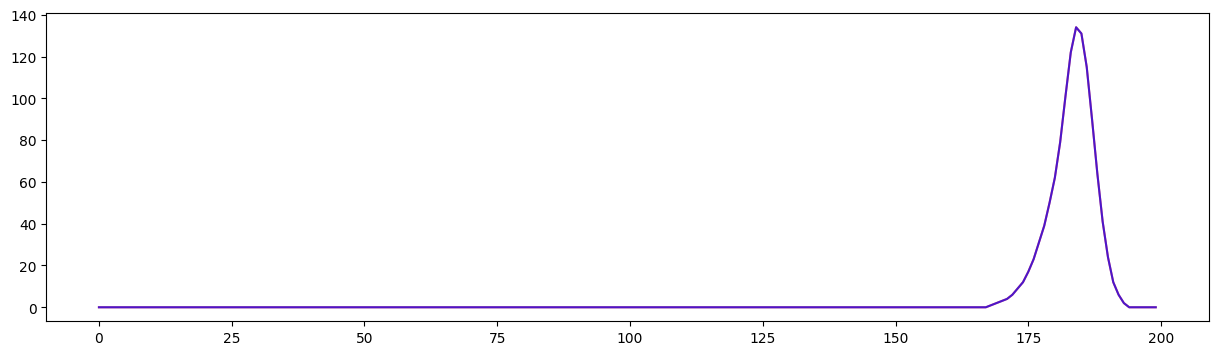

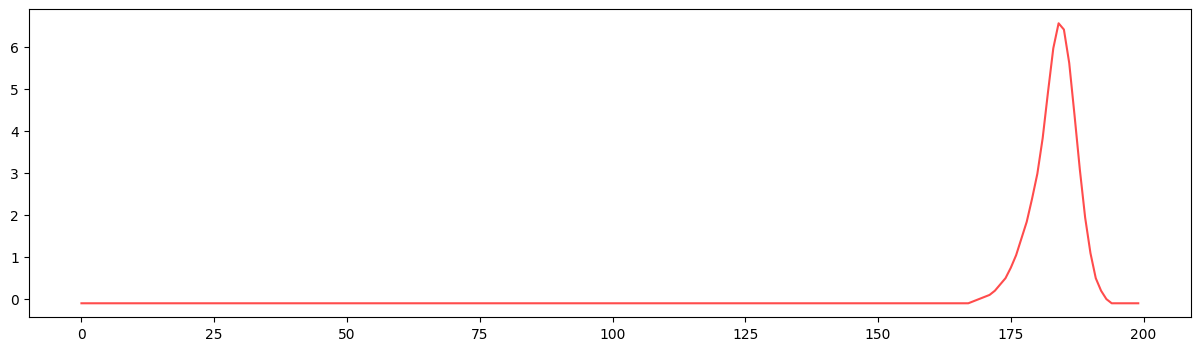

In [11]:
fig = plt.subplots(figsize=(15, 4), facecolor='white')
plt.plot(y_train[idx],color='red', label='target', alpha=0.7)
plt.plot(y_train_scaled[idx]*std + mean,color='blue', label='target', alpha=0.7)

fig = plt.subplots(figsize=(15, 4), facecolor='white')
plt.plot(y_train_scaled[idx],color='red', label='target', alpha=0.7)

In [ ]:
model = load_model('../../latest_models/model_' + wireplane + 'plane_nu.h5')
autoencoder = Autoencoder(200, model, x_train_scaled)
compiled_model = autoencoder.create_model()